# LSTM model
We also tried ARIMA and other types of NN, but:
 - ARIMA is insanely slow, so it is unlikely that it would fit in this contex of predicting prices, where we are counting on every second
 - Other types of NNs are probably viable if pre-trained, but LSTM showed best results

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [2]:
# Read data:
volue_data = pd.read_csv('../data/volue_data.csv')
volue_data = volue_data.rename(columns={'Unnamed: 0': 'ts', 'price_intraday':'price'})
volue_data['ts'] = pd.to_datetime(volue_data['ts'], utc = True)

In [3]:
volue_data['ts'] = pd.to_datetime(volue_data['ts'], utc = True)

In [4]:
volue_data

,ts,wind_pred,wind_actual,solar_pred,solar_actual,price
0,2021-01-31 23:00:00+00:00,11918.194388,12852.0,0.0,0.0,38.7800
1,2021-01-31 23:15:00+00:00,11918.194388,13028.0,0.0,0.0,38.4350
2,2021-01-31 23:30:00+00:00,11918.194388,12957.0,0.0,0.0,38.0900
3,2021-01-31 23:45:00+00:00,11918.194388,13024.0,0.0,0.0,37.7450
4,2021-02-01 00:00:00+00:00,12895.707993,13246.0,0.0,0.0,37.4000
...,...,...,...,...,...,...
2583,2021-02-27 21:45:00+00:00,8023.223248,8072.0,0.0,0.0,38.1025
2584,2021-02-27 22:00:00+00:00,8013.186187,8109.0,0.0,0.0,38.2400
2585,2021-02-27 22:15:00+00:00,8013.186187,7976.0,0.0,0.0,38.2400
2586,2021-02-27 22:30:00+00:00,8013.186187,7856.0,0.0,0.0,38.2400


In [5]:
volue_data = volue_data[:191]

In [6]:
# Read data:
series = TimeSeries.from_dataframe(volue_data, 'ts', ['price'])

test_start_timestamp = pd.Timestamp(volue_data['ts'].iloc[-13])
# Create training and validation sets:
train, val = series.split_after(test_start_timestamp)

In [7]:

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [8]:
#Our rolling window parameters
train_window = 12
train_rollover_size = 1

In [9]:
my_model = RNNModel(
    model='LSTM',
    input_chunk_length=train_window,
    output_chunk_length=train_rollover_size ,
    hidden_size=25,
    n_rnn_layers=1,
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42
)

In [10]:
my_model.fit(train_transformed, val_series=val_transformed, verbose=True)  # 107

Training loss: 0.0008, validation loss: nan, best val loss: inf


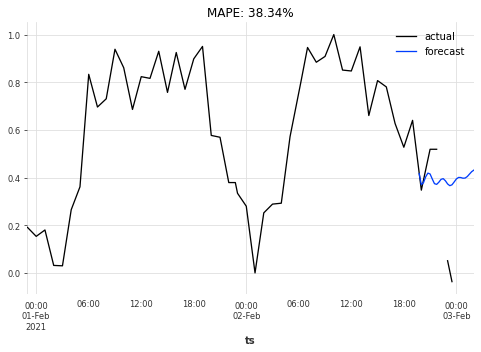

In [11]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

### Backtesting

In [12]:
backtest_series = my_model.historical_forecasts(series_transformed,
                                                start=test_start_timestamp,
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

MAPE: 22.35%


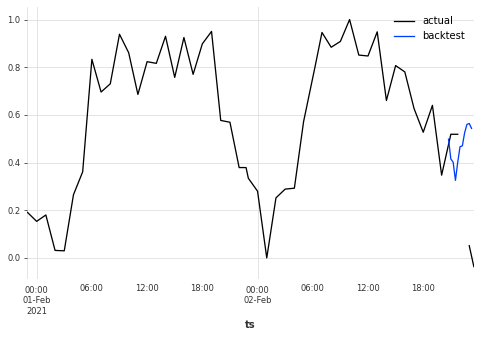

In [13]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))

In [14]:
lstm_predicted = backtest_series.pd_dataframe()
lstm_predicted['ts'] = lstm_predicted.index
lstm_predicted = lstm_predicted.rename(columns={'0':'price_diff'})

In [15]:
results = pd.merge(volue_data, lstm_predicted, on='ts')

In [16]:
results['price_predicted'] = results['price'] + results['price_diff']

In [17]:
results[['ts', 'price', 'price_predicted', 'price_diff']][-12:].to_csv('../results/results.csv')